In [1]:
%matplotlib inline

In [2]:
import os
import netCDF4
import numpy as np
from geophys_utils import NetCDFLineUtils
import matplotlib.pyplot as plt
from geophys_utils import array2file
from osgeo import gdal
from geophys_utils import CSWUtils
import os
import re
from netCDF4 import Dataset
from pprint import pprint
import requests
import math
from scipy.interpolate import griddata
from geophys_utils import transform_coords, get_utm_wkt, get_spatial_ref_from_wkt

In [3]:
# Import demo functions. Note that CSW URL and proxy may need to be edited.
from line_data_demo import get_netcdf_datasets, dataset_point_generator, get_points_from_dict, get_points_from_datasets, grid_points

In [4]:
# Set up search criteria
wgs84_bounds = (120.0, -29.0, 121, -28) # Spatial subset of dataset in WGS84 coordinates
keywords = 'geophysics,airborne digital data,geophysical survey,magnetics,line,AWAGS' # Comma-separated list of keywords

In [5]:
# Calculate extra spatial information about area of interest
wgs84_wkt = get_spatial_ref_from_wkt('EPSG:4326').ExportToWkt()

wgs84_centre_coords = [(wgs84_bounds[dim_index] + wgs84_bounds[dim_index+2]) / 2.0 for dim_index in range(2)]

utm_wkt = get_utm_wkt(wgs84_centre_coords, wgs84_wkt)

reprojected_bounding_box = np.array(transform_coords(((wgs84_bounds[0], wgs84_bounds[1]), 
                                                      (wgs84_bounds[2], wgs84_bounds[1]), 
                                                      (wgs84_bounds[2], wgs84_bounds[3]), 
                                                      (wgs84_bounds[0], wgs84_bounds[3])
                                                      ), 
                                                      wgs84_wkt, utm_wkt))
utm_bounds = [min(reprojected_bounding_box[:,0]), 
              min(reprojected_bounding_box[:,1]), 
              max(reprojected_bounding_box[:,0]), 
              max(reprojected_bounding_box[:,1])]


In [6]:
# Find all NetCDF paths using CSW
netcdf_list = sorted(get_netcdf_datasets(keywords, wgs84_bounds))
print '\n'.join(netcdf_list)

Unable to open CSW URL https://dev.public.ecat.ga.gov.au/geonetwork/srv/eng/csw: HTTPSConnectionPool(host='dev.public.ecat.ga.gov.au', port=443): Max retries exceeded with url: /geonetwork/srv/eng/csw?version=2.0.2&request=GetCapabilities&service=CSW (Caused by SSLError(CertificateError("hostname 'dev.public.ecat.ga.gov.au' doesn't match '*.ecat.ga.gov.au'",),))
Querying CSW
11 matching dataset records found from CSW
11 NetCDF distributions found
/g/data2/uc0/rr2_dev/rcb547/AWAGS_Levelled_Line_Databases/mag_database_reformat_2016_adjusted/netcdf/GSWA_P1260MAG.nc
/g/data2/uc0/rr2_dev/rcb547/AWAGS_Levelled_Line_Databases/mag_database_reformat_adjusted/netcdf/P288MAGA.nc
/g/data2/uc0/rr2_dev/rcb547/AWAGS_Levelled_Line_Databases/mag_database_reformat_adjusted/netcdf/P288MAGB.nc
/g/data2/uc0/rr2_dev/rcb547/AWAGS_Levelled_Line_Databases/mag_database_reformat_adjusted/netcdf/P342MAG.nc
/g/data2/uc0/rr2_dev/rcb547/AWAGS_Levelled_Line_Databases/mag_database_reformat_adjusted/netcdf/P354MAG.nc
/

In [7]:
# Retrieve all points in bounding box from NetCDF files in UTM projection
# N.B: This may take some time depending on the size of the bounds and the number and size of line datasets
# dataset_point_dict: {<dataset_path>: (<coordinates>, <values>),...}
dataset_point_dict = {dataset: (coordinates, values)
                      for dataset, coordinates, values in dataset_point_generator(netcdf_list, 
                                                                                  wgs84_bounds, 
                                                                                  'mag_awags', 
                                                                                  utm_wkt)
                      }

Reading and reprojecting points from line dataset /g/data2/uc0/rr2_dev/rcb547/AWAGS_Levelled_Line_Databases/mag_database_reformat_2016_adjusted/netcdf/GSWA_P1260MAG.nc
133140/13313778 points found in bounding box
Discarding 131 invalid values
133009 valid points were found
Reading and reprojecting points from line dataset /g/data2/uc0/rr2_dev/rcb547/AWAGS_Levelled_Line_Databases/mag_database_reformat_adjusted/netcdf/P288MAGA.nc
3862/189497 points found in bounding box
Discarding 11 invalid values
3851 valid points were found
Reading and reprojecting points from line dataset /g/data2/uc0/rr2_dev/rcb547/AWAGS_Levelled_Line_Databases/mag_database_reformat_adjusted/netcdf/P288MAGB.nc
110677/179223 points found in bounding box
Reading and reprojecting points from line dataset /g/data2/uc0/rr2_dev/rcb547/AWAGS_Levelled_Line_Databases/mag_database_reformat_adjusted/netcdf/P342MAG.nc
20/335476 points found in bounding box
Reading and reprojecting points from line dataset /g/data2/uc0/rr2_dev/r

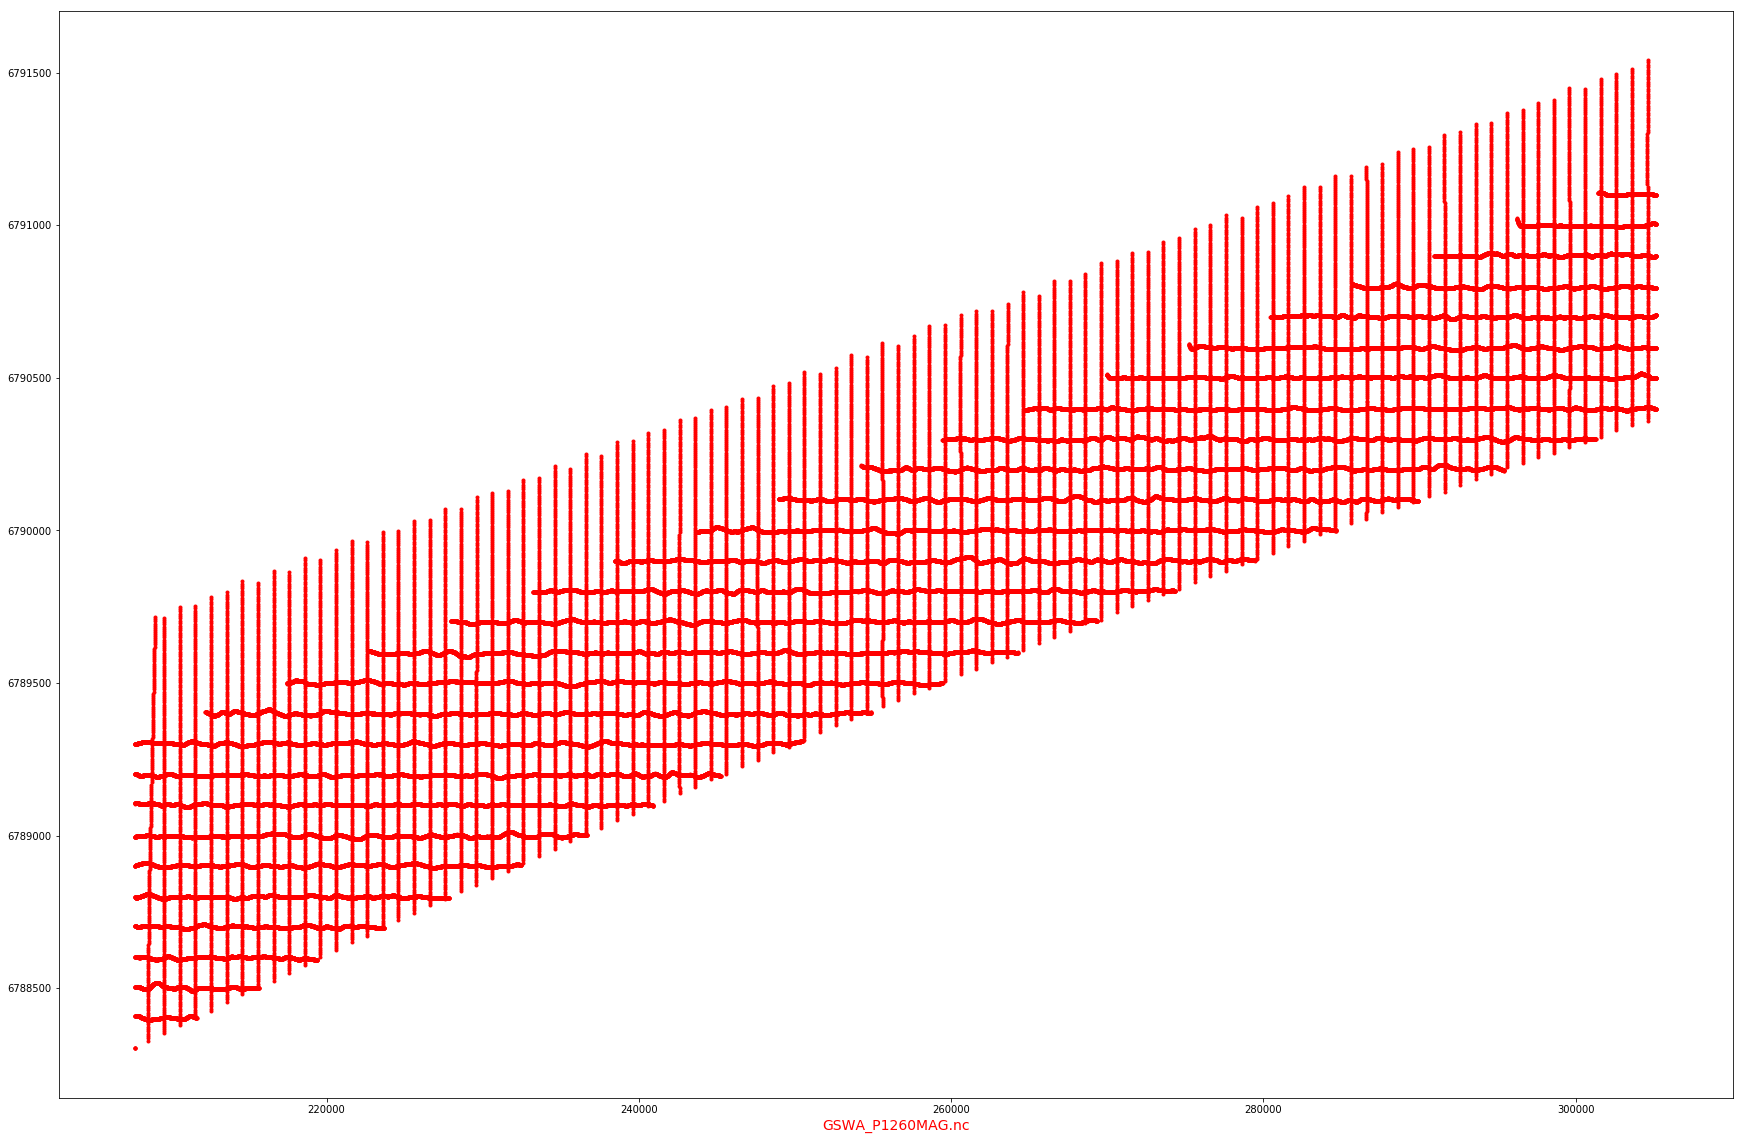

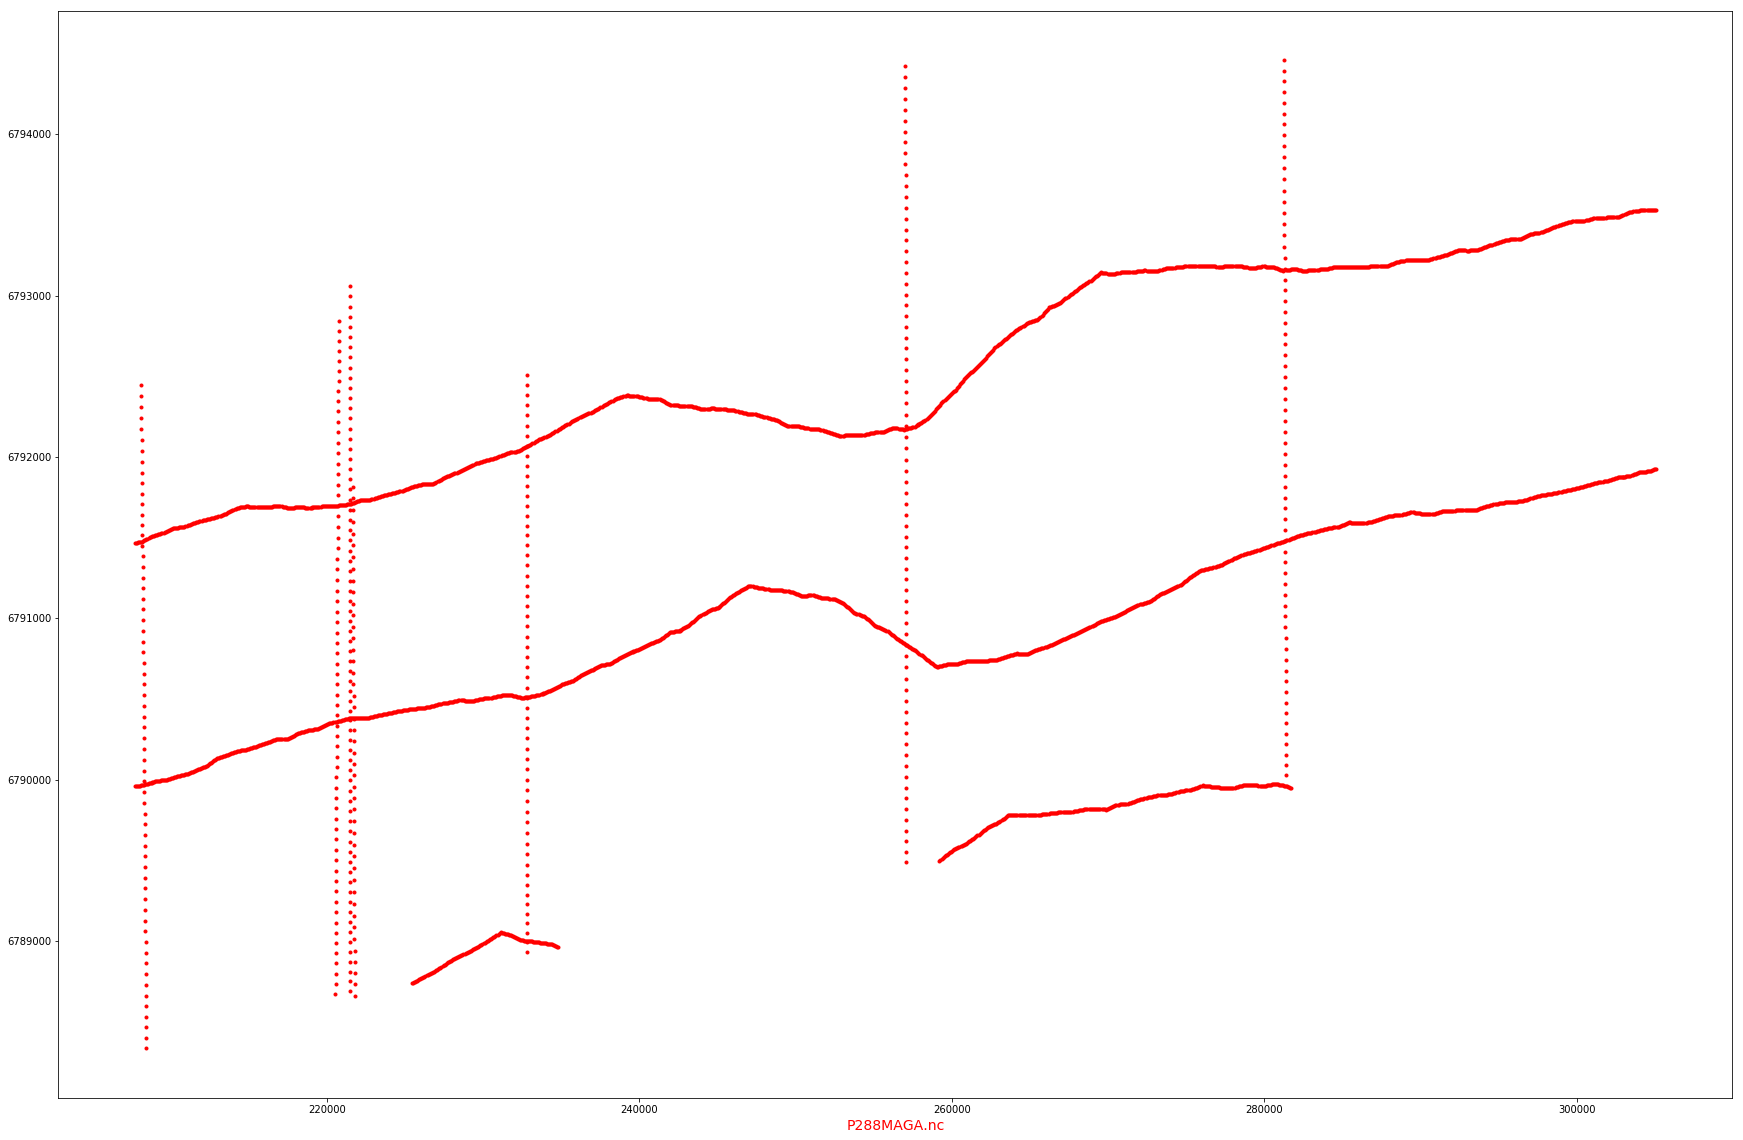

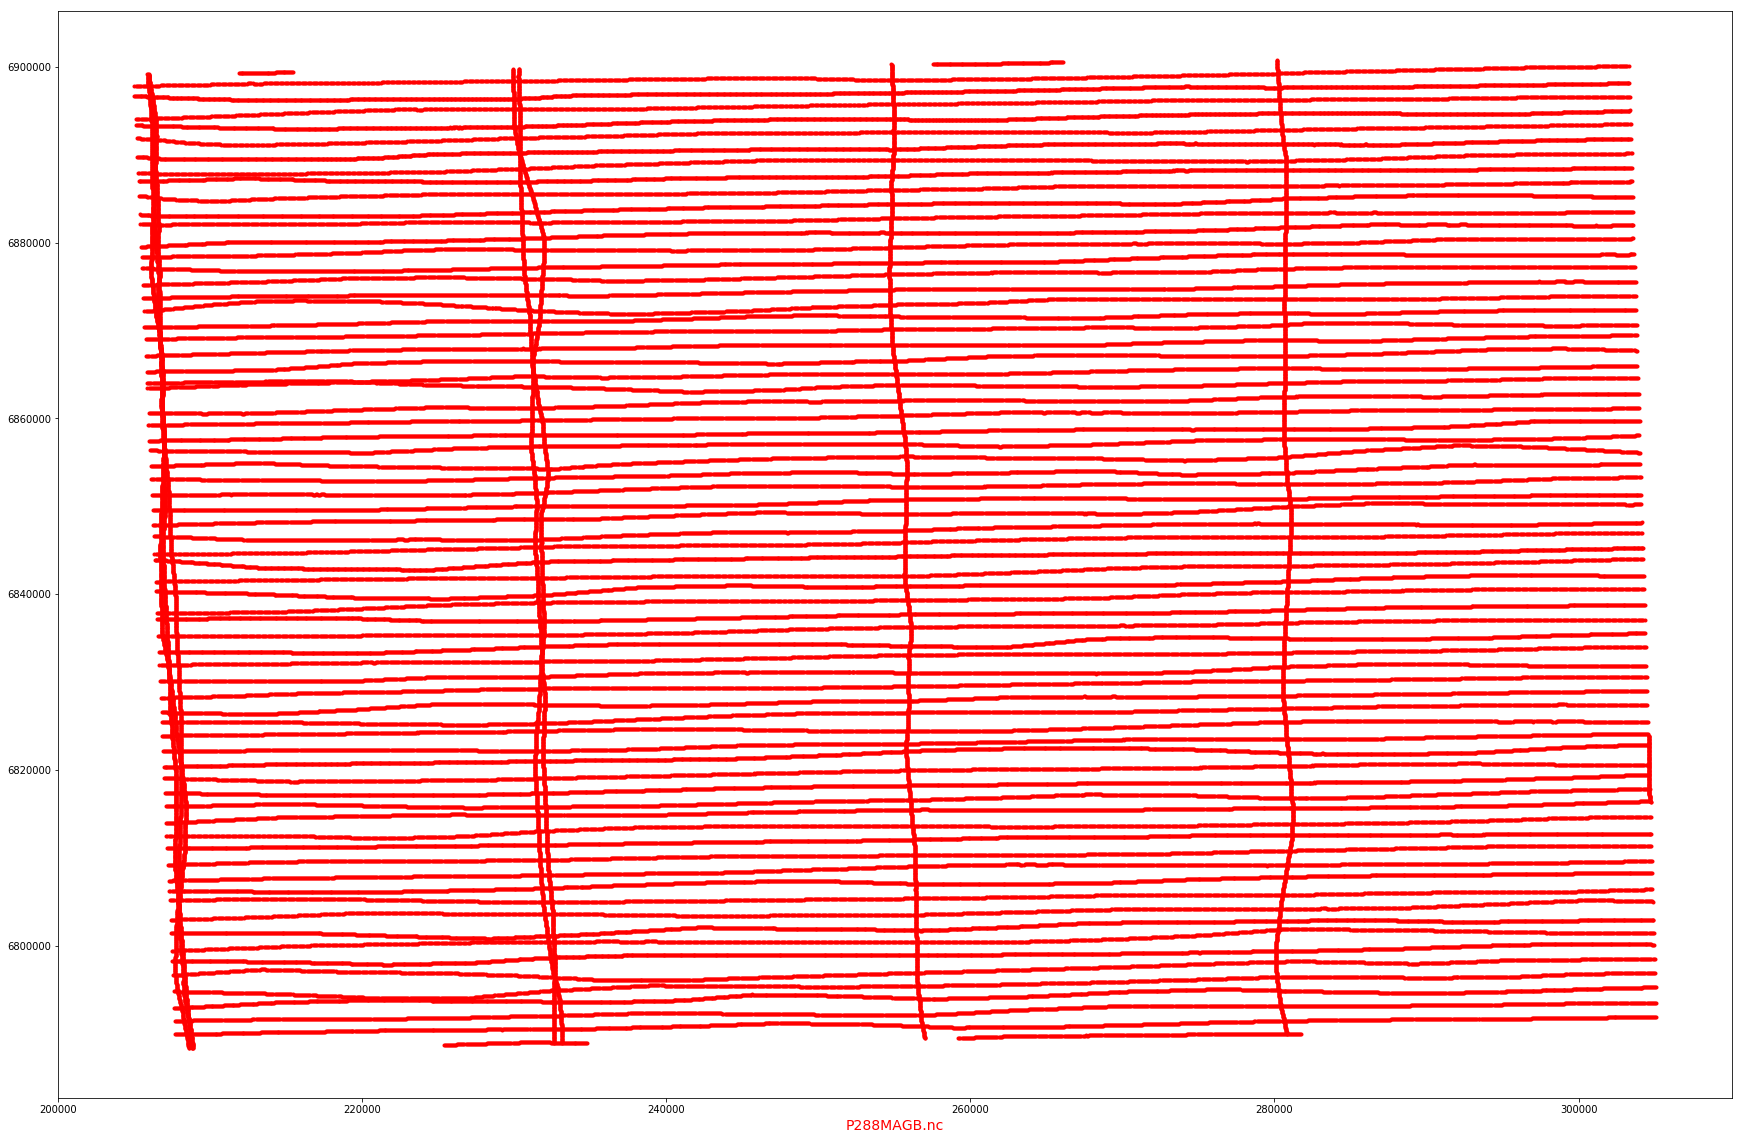

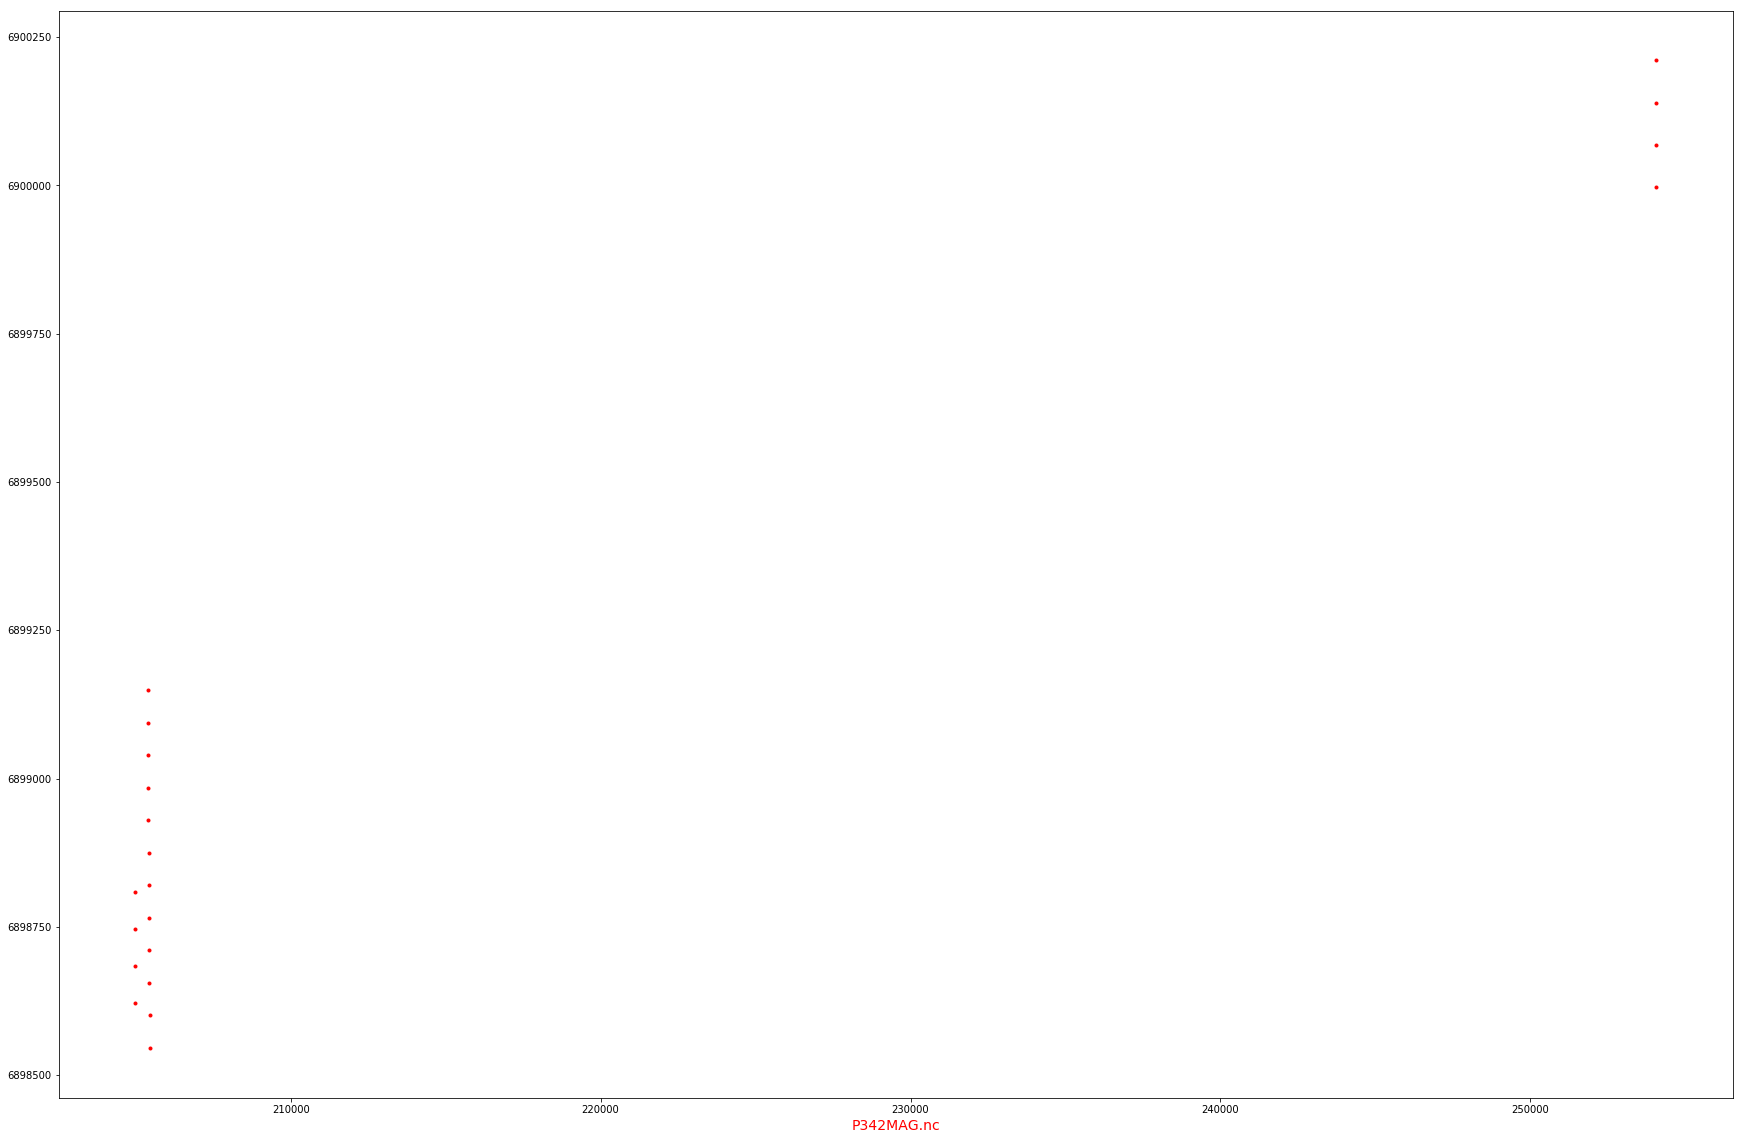

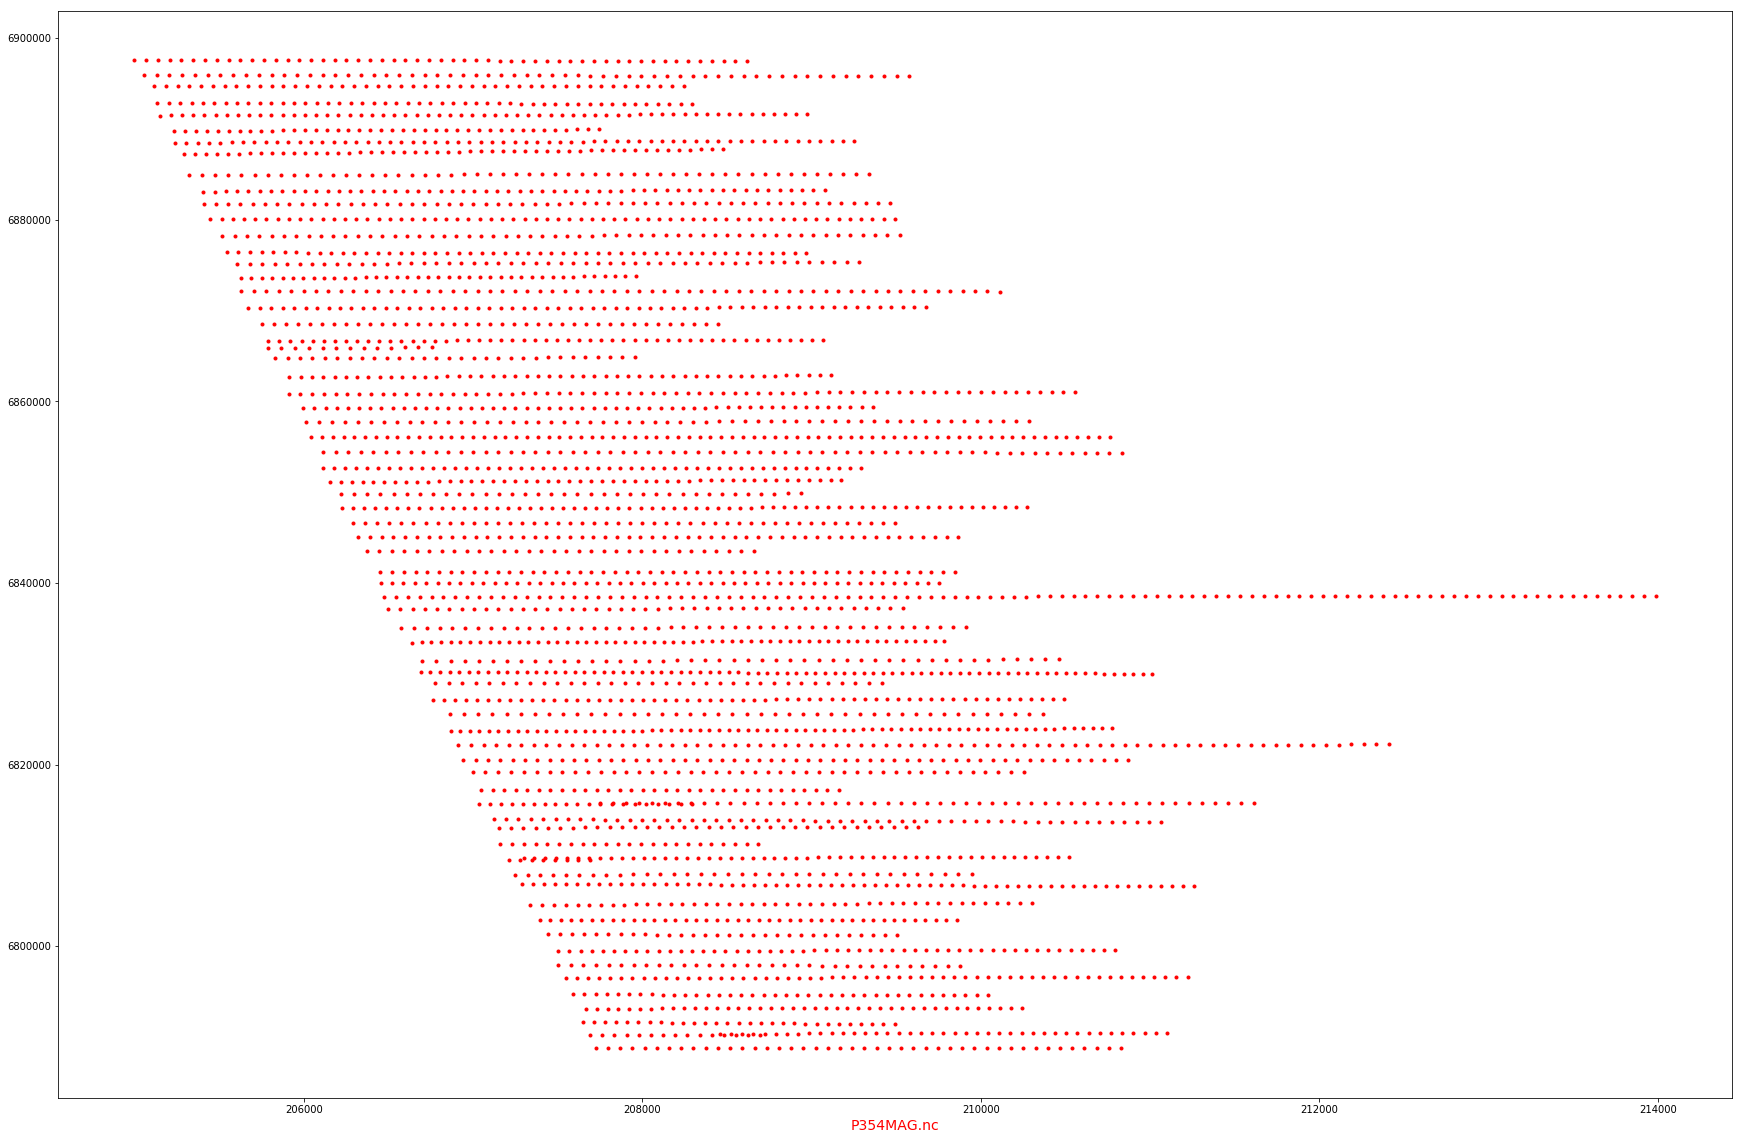

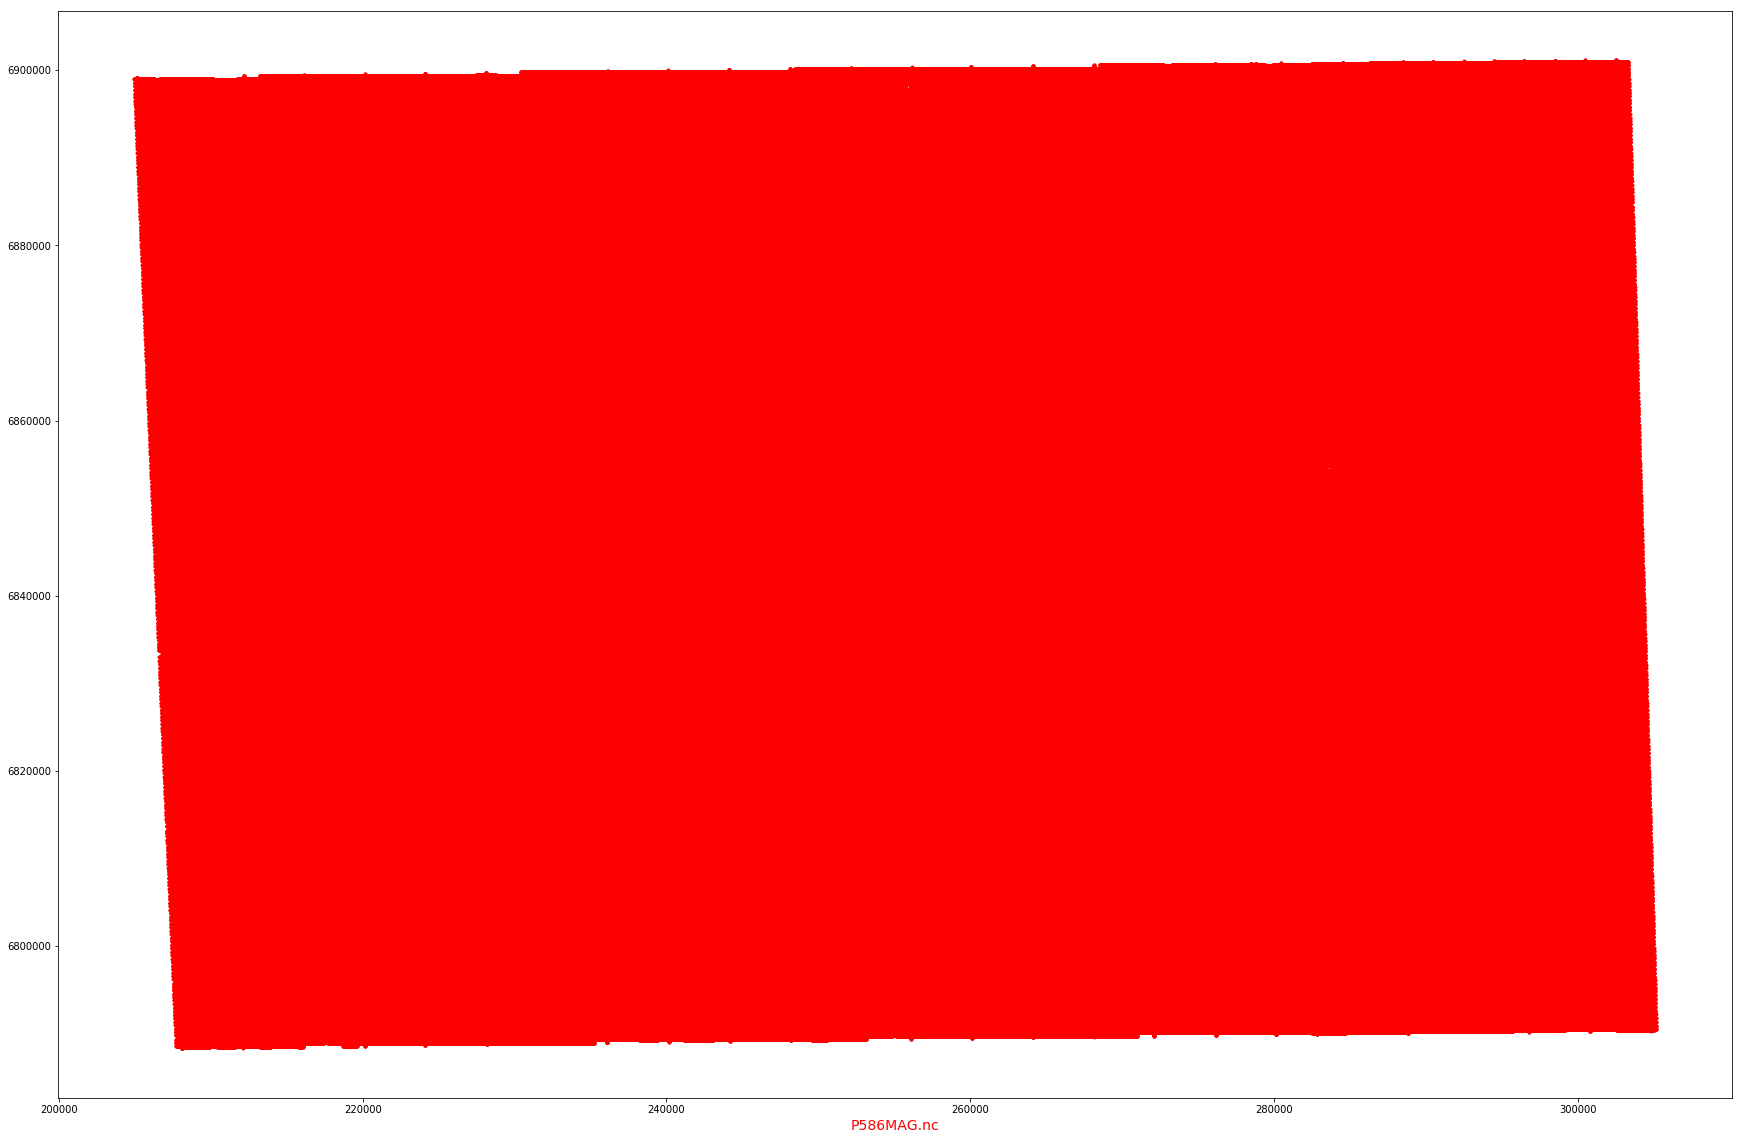

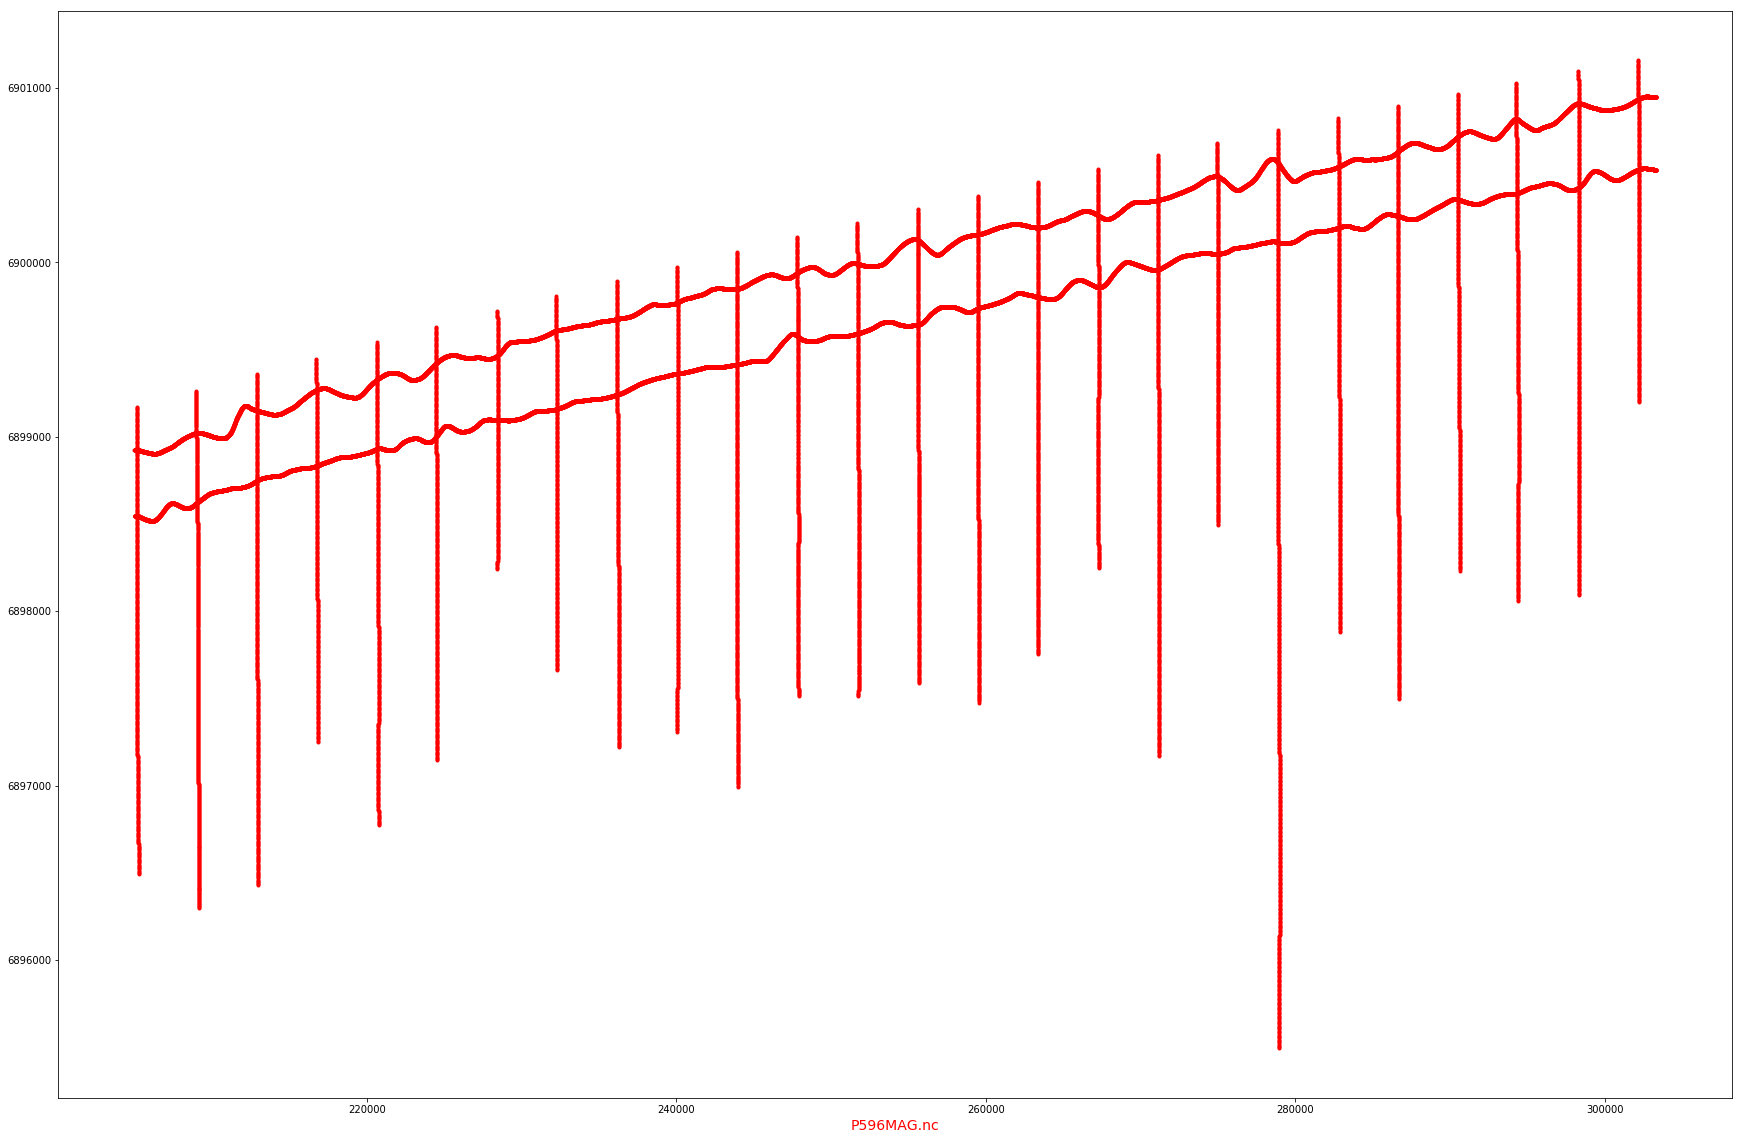

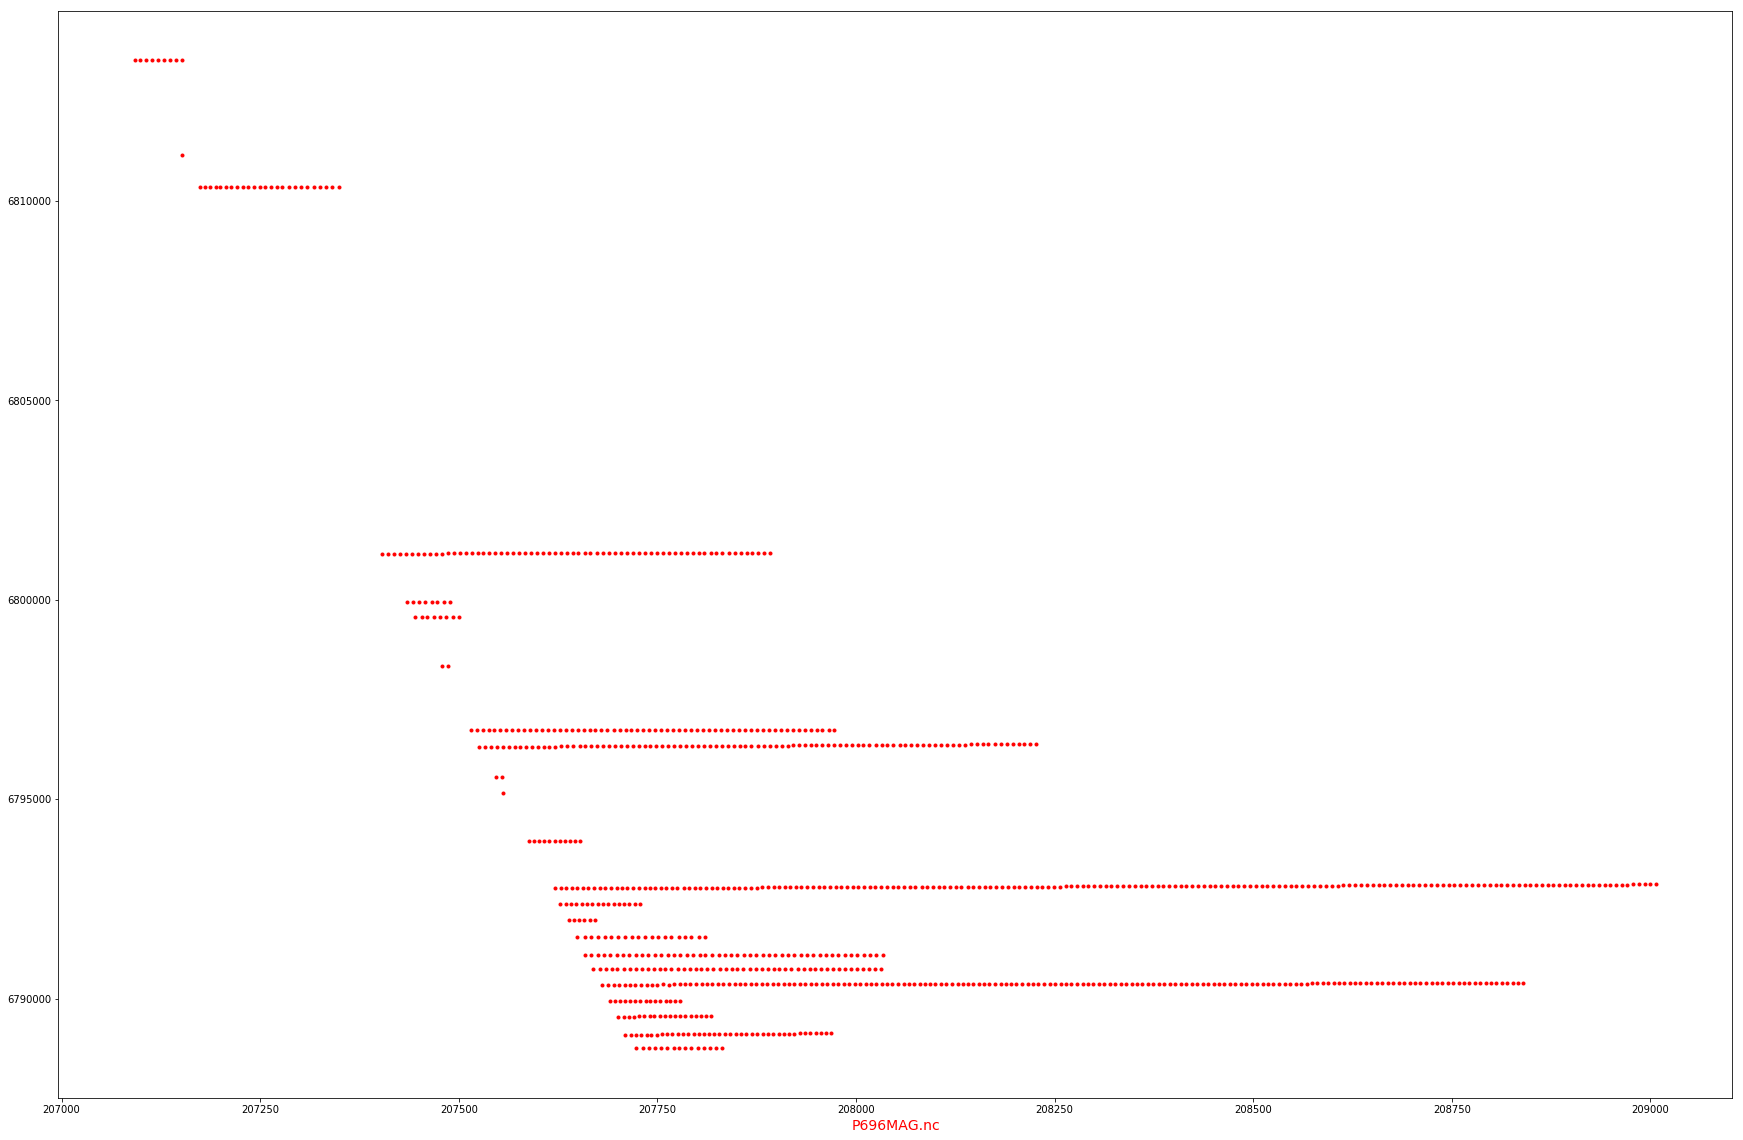

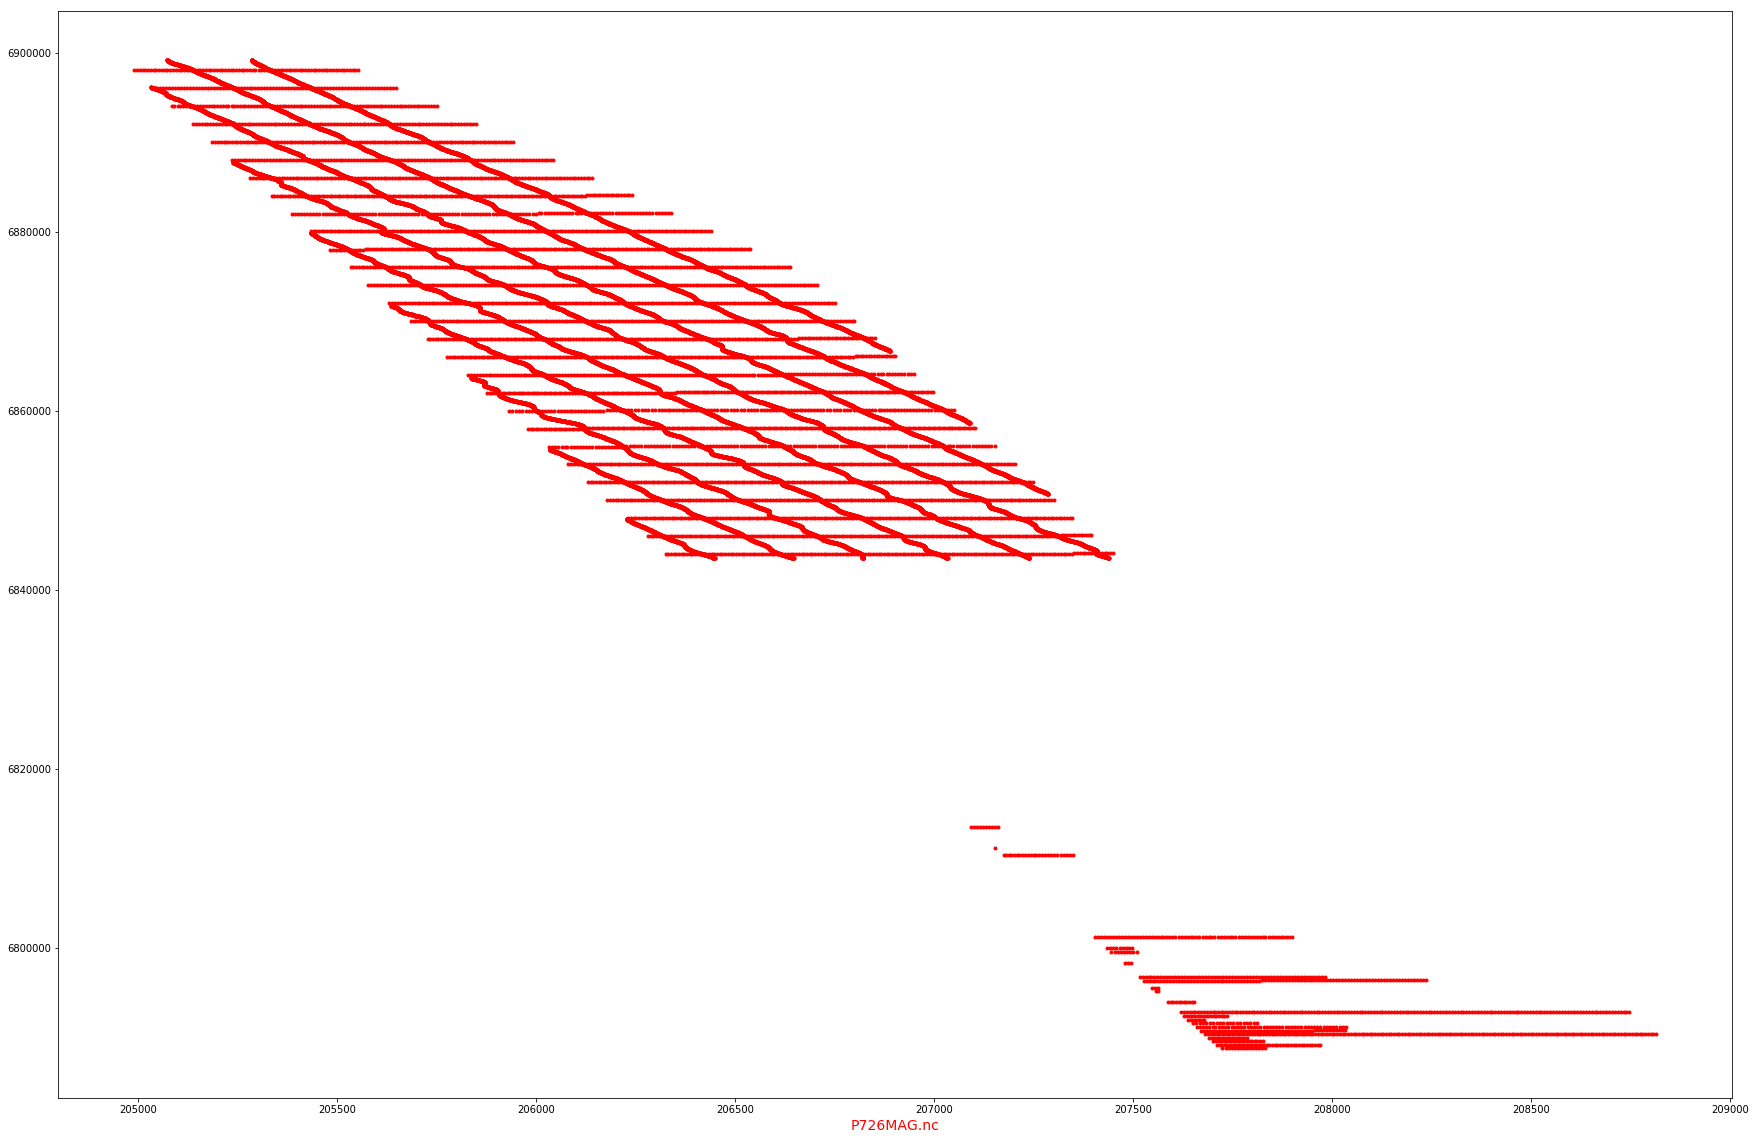

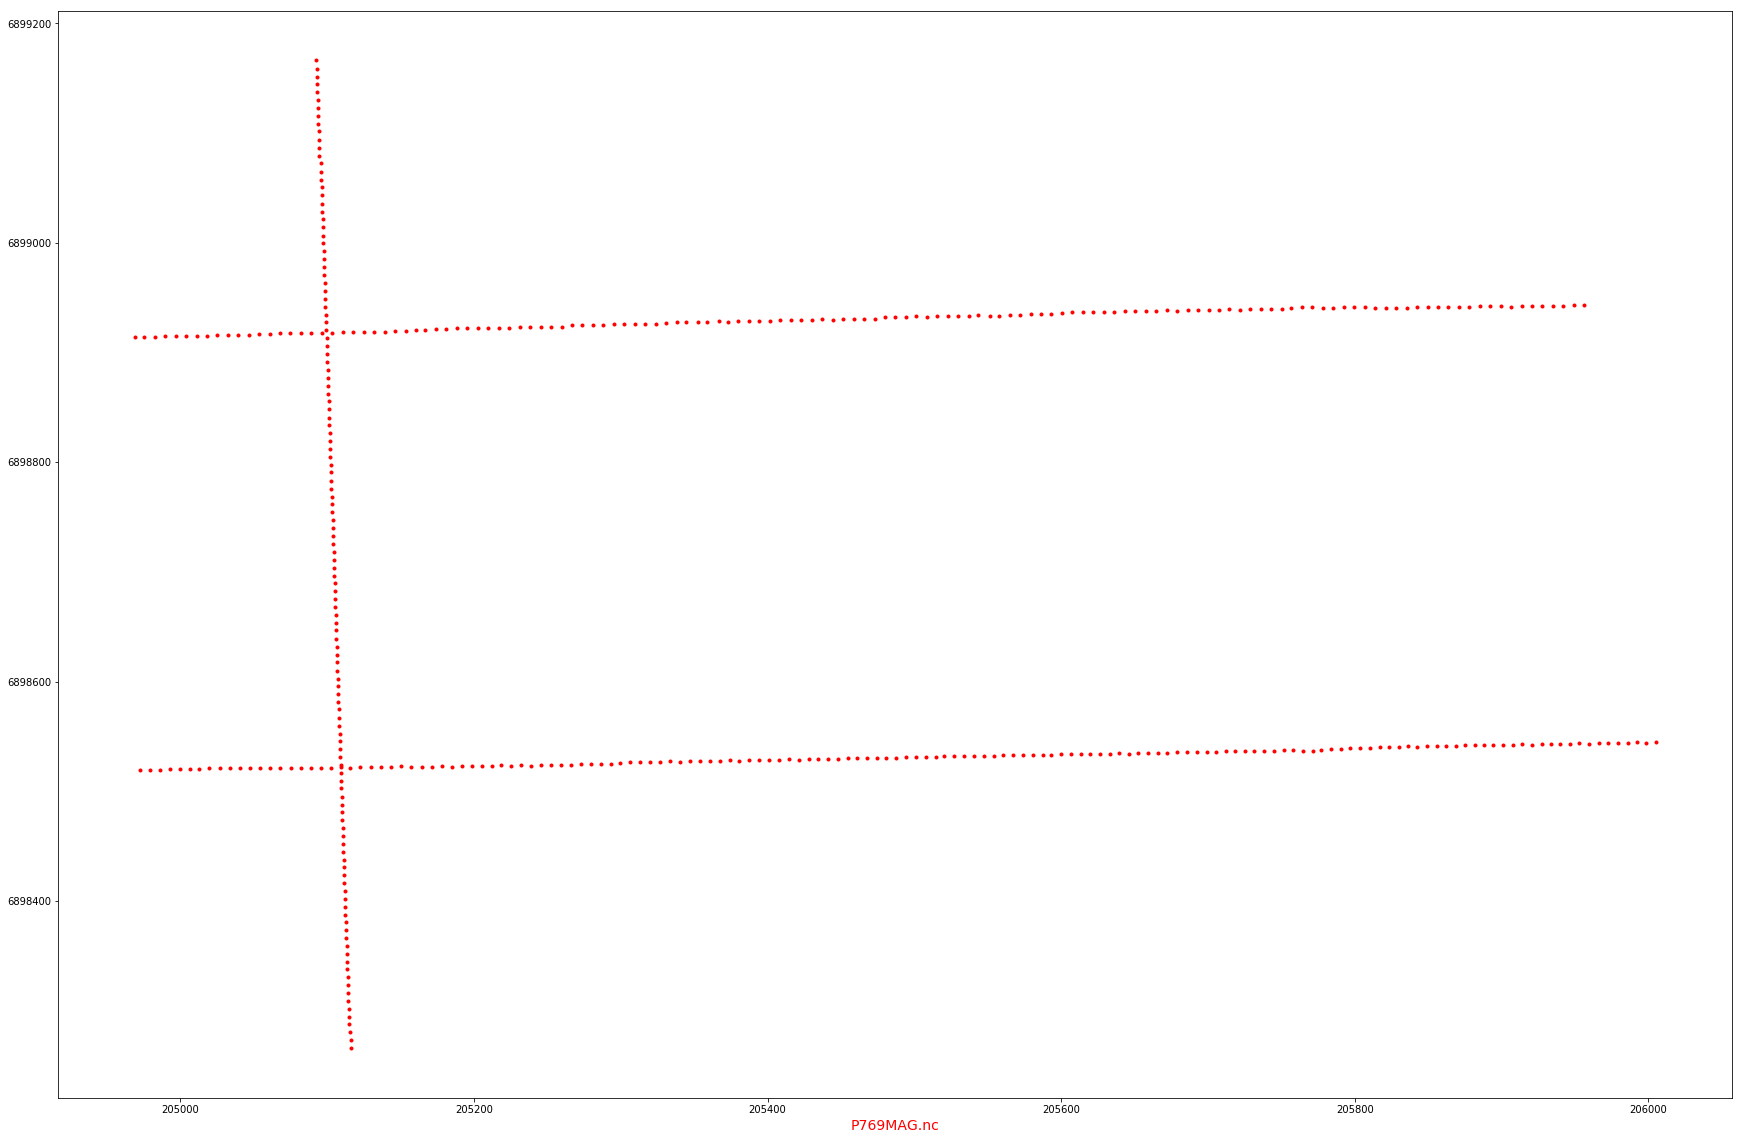

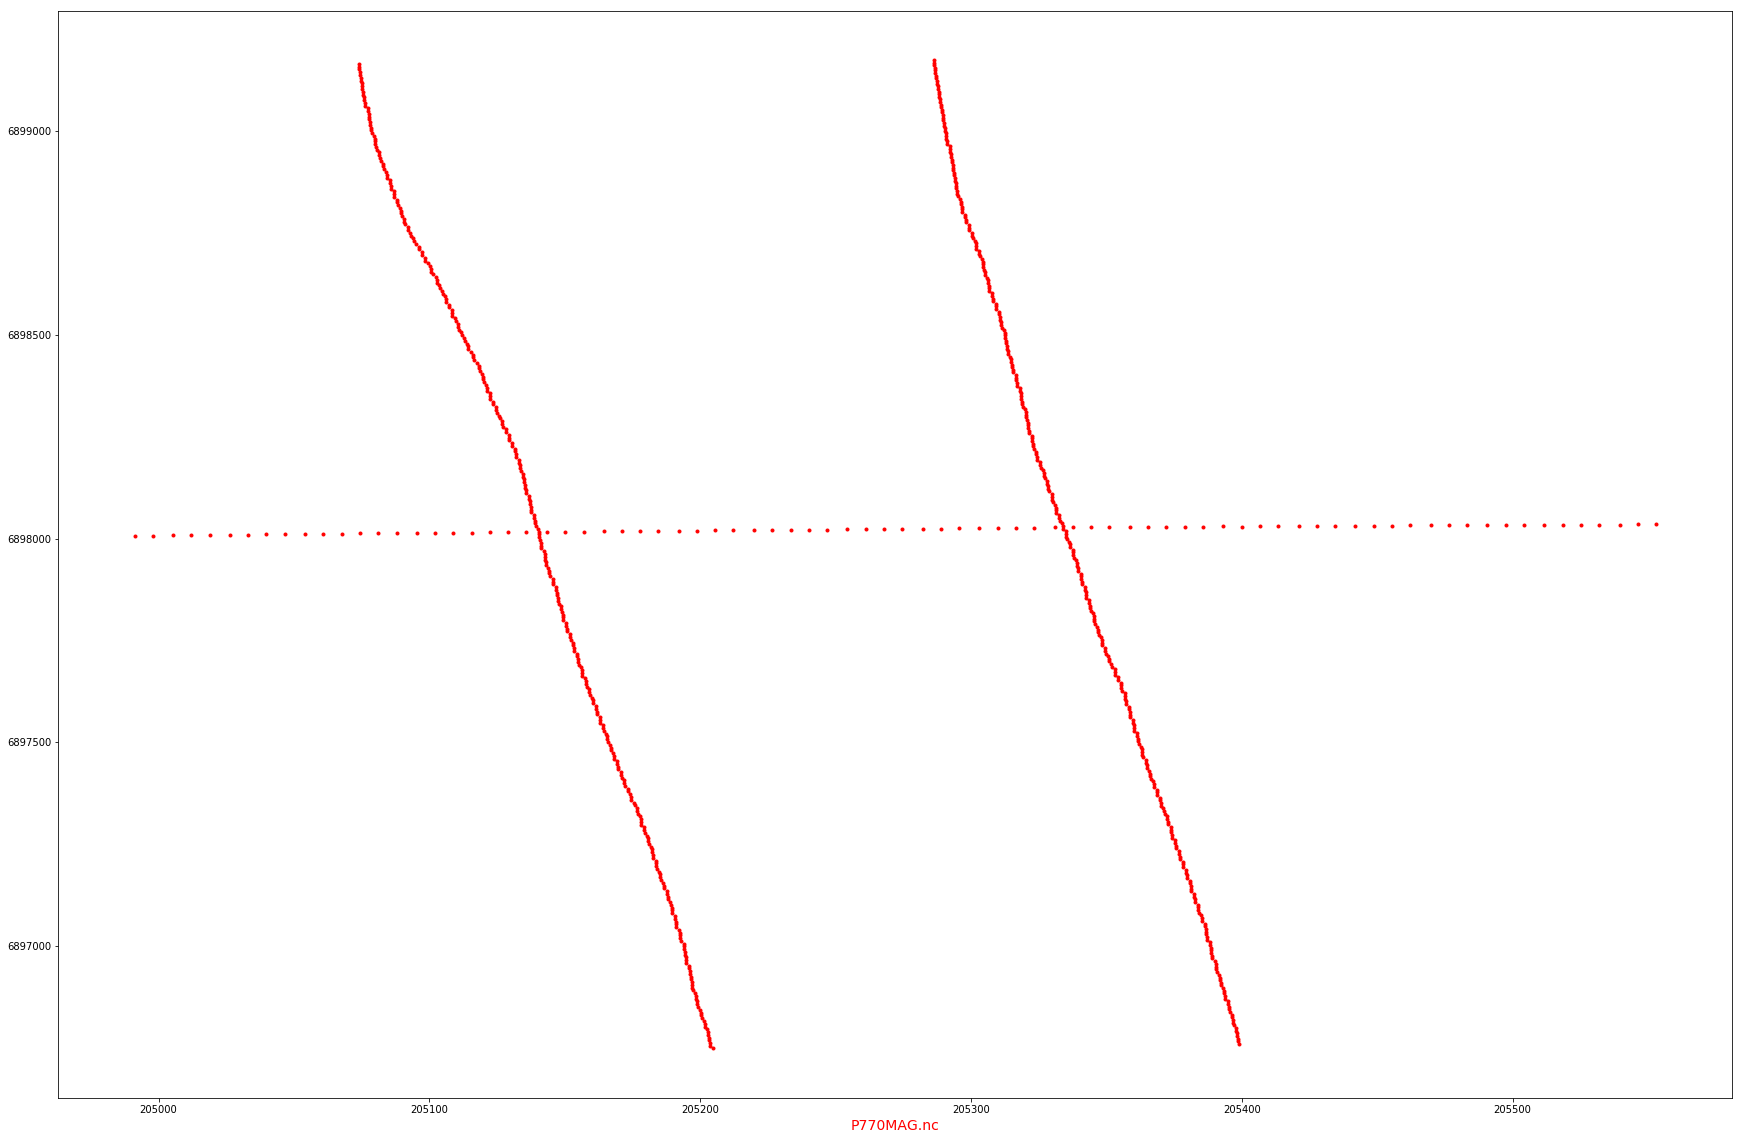

In [8]:
# Plot points for each dataset
for dataset in sorted(dataset_point_dict.keys()):
    coordinates, _values = dataset_point_dict[dataset]
    plt.figure(figsize=(30,20))
    plt.xlabel(os.path.basename(dataset), fontsize=14, color='red')
    plt.plot(coordinates[:,0], coordinates[:,1], 'r.')


In [9]:
# Retrieve all points in bounding box from NetCDF files in UTM projection
all_coordinates, all_values = get_points_from_dict(dataset_point_dict)

Converting lists to arrays
A total of 3084934 points were read from 11 line datasets


In [10]:
# Interpolate points to grid
# WGS84_BOUNDS in UTM would be [204956.51141957112, 6788302.6266548373, 305179.01592085767, 6901185.7464002995]
grid_bounds = [207000, 6800000, 303000, 6899000]

utm_mag_awags_grid, wkt, geotransform = grid_points(coordinates=all_coordinates,
                                 coordinate_wkt=utm_wkt,
                                 values=all_values,
                                 grid_wkt=utm_wkt, 
                                 grid_bounds=grid_bounds,
                                 grid_resolution=100.0, 
                                 resampling_method='linear', 
                                 point_step=1
                                 )

Reprojecting coordinates
Computing spatial mask
Generating grid coordinates
Generating spatial subset mask
Interpolating 2517739 points
Interpolation complete


In [11]:
# Print some stats from the grid
print 'Shape: ', utm_mag_awags_grid.shape
print 'Min:  ', np.nanmin(utm_mag_awags_grid)
print 'Mean: ', np.nanmean(utm_mag_awags_grid)
print 'Max:  ', np.nanmax(utm_mag_awags_grid)
print 'geotransform: ', geotransform
print 'wkt: ', wkt

Shape:  (991, 961)
Min:   -2637.04129403
Mean:  5.06638913638
Max:   7390.86851756
geotransform:  [206950.0, 100.0, 0, 6899050.0, 0, -100.0]
wkt:  PROJCS["UTM Zone 51, Southern Hemisphere",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],TOWGS84[0,0,0,0,0,0,0],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9108"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",123],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",10000000],UNIT["Meter",1]]


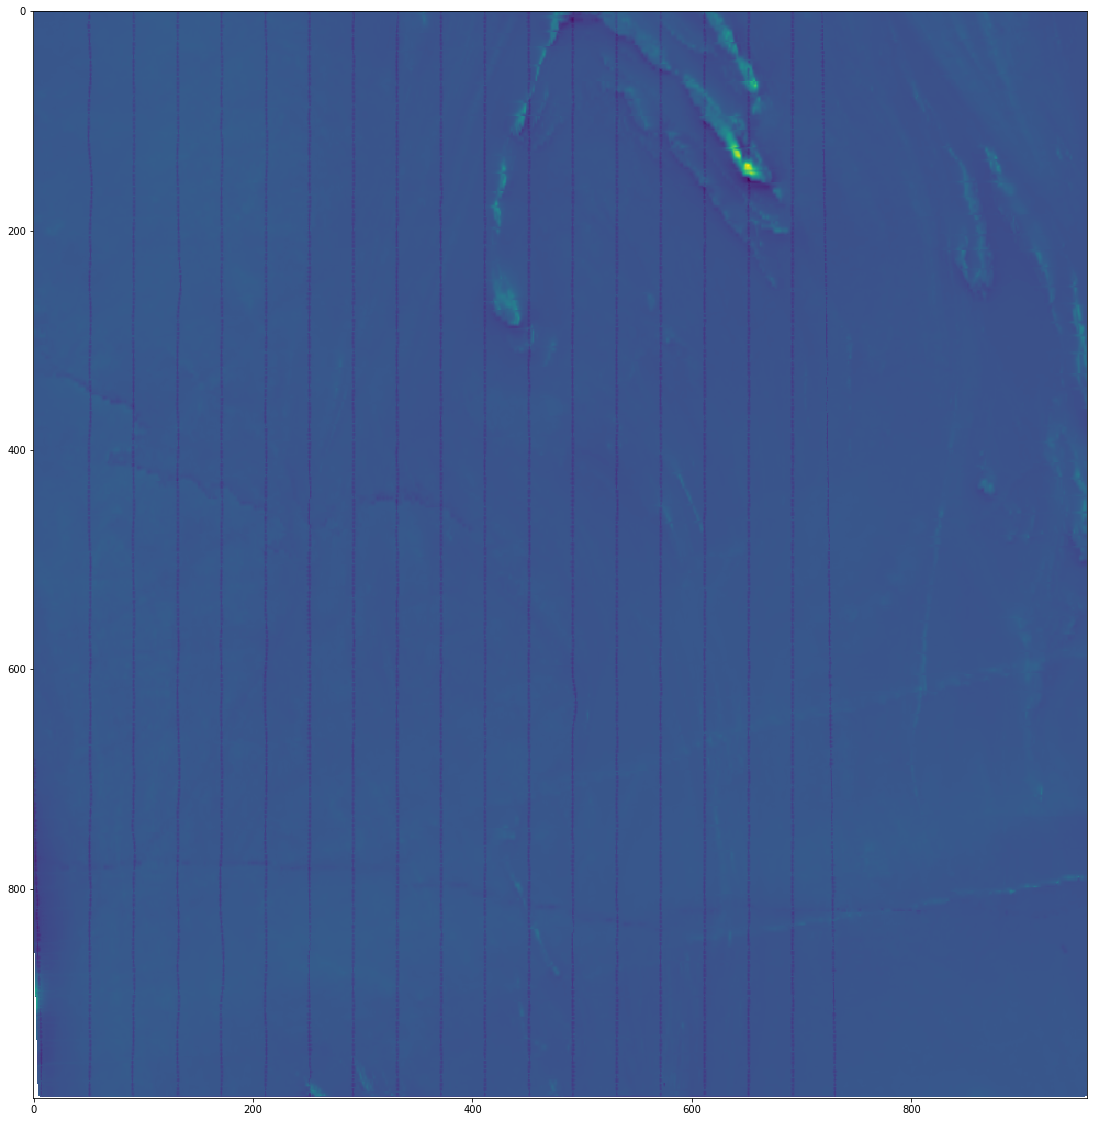

In [12]:
# Plot interpolated grid
plt.figure(figsize=(30,20))    
plt.imshow(utm_mag_awags_grid)

In [13]:
# Save the array to a GeoTIFF file on disk
gdal_dataset = array2file([utm_mag_awags_grid], wkt, geotransform, 'utm_mag_awags_grid.tif', 'GTiff')

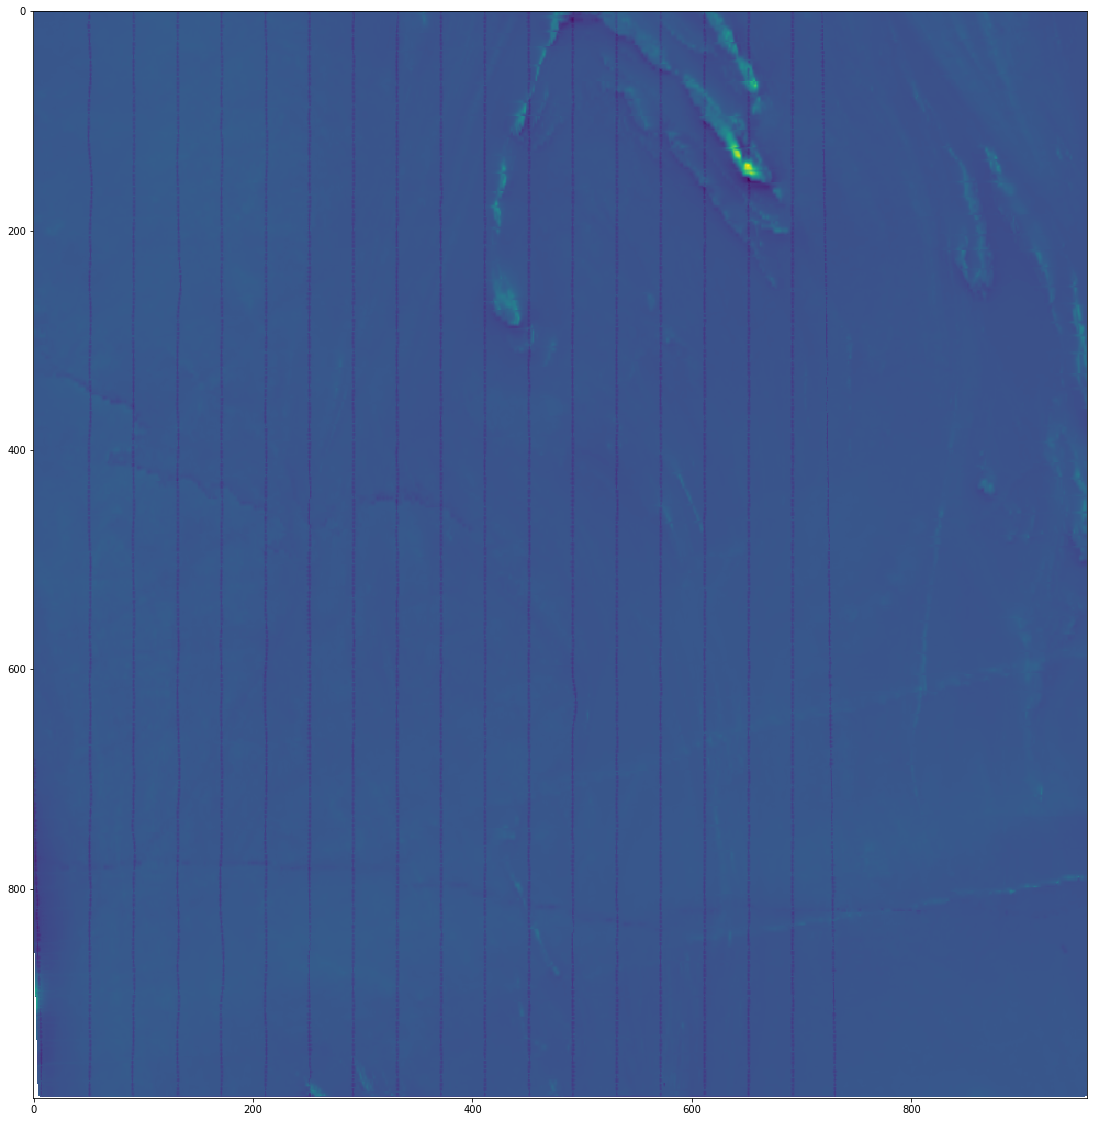

In [14]:
# Reload and replot image from GeoTIFF file as a test
del gdal_dataset
gdal_dataset = gdal.Open('utm_mag_awags_grid.tif')
plt.figure(figsize=(30,20))    
plt.imshow(gdal_dataset.GetRasterBand(1).ReadAsArray())
del gdal_dataset